# Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error

%config IPCompleter.greedy=True

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

import pickle

In [2]:

x = pd.read_pickle('../../02_Data/03_Work/x_preselected.pickle')
y = pd.read_pickle('../../02_Data/03_Work/y_preselected.pickle')


## Modeling for a product

In [3]:
x = x.loc[(x.store_id == 'CA_3') & (x.item_id == 'FOODS_3_586')]

In [4]:
y = y[y.index.isin(x.index)]

In [5]:
var_modeling = x.columns.to_list()[3:]

In [6]:
# crossval specific to time series

time_cv = TimeSeriesSplit(3, test_size = 8) # predict at 8 days in future

#### pipe and dict of algorythms, params and values to test

In [7]:
pipe = Pipeline([('algorythm',HistGradientBoostingRegressor())])

grid = [{'algorythm': [HistGradientBoostingRegressor()],
         'algorythm__learning_rate': [0.01,0.025,0.05,0.1],
         'algorythm__max_iter': [50,100,200],
         'algorythm__max_depth': [None, 5,10,20],
         'algorythm__min_samples_leaf': [20, 500],
         'algorythm__l2_regularization': [0,0.25,0.5,0.75,1]
        }]

random_search = RandomizedSearchCV(estimator = pipe,
                                   param_distributions = grid, 
                                   n_iter = 30, 
                                   cv = time_cv, 
                                   scoring = 'neg_mean_absolute_error', 
                                   verbose = 0,
                                   n_jobs = -1)

model = random_search.fit(x[var_modeling],y)

pd.DataFrame(random_search.cv_results_).sort_values(by = 'rank_test_score').head(3)


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1            0.43          0.01             0.00            0.00   
14           1.56          0.16             0.01            0.00   
4            0.99          0.02             0.00            0.00   

   param_algorythm__min_samples_leaf param_algorythm__max_iter  \
1                                 20                       100   
14                                20                       200   
4                                 20                       100   

   param_algorythm__max_depth param_algorythm__learning_rate  \
1                           5                           0.05   
14                         10                           0.05   
4                          10                           0.05   

   param_algorythm__l2_regularization                  param_algorythm  \
1                                0.25  HistGradientBoostingRegressor()   
14                               0.25  HistGradientBoostingRegressor()   
4                                   1  HistGradientBoostingRegressor()   

                                               params  split0_test_score  \
1   {'algorythm__min_samples_leaf': 20, 'algorythm...              -8.26   
14  {'algorythm__min_samples_leaf': 20, 'algorythm...              -8.91   
4   {'algorythm__min_samples_leaf': 20, 'algorythm...              -8.86   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
1              -15.30             -14.14           -12.57            3.08   
14             -14.47             -14.98           -12.79            2.75   
4              -14.60             -15.71           -13.06            3.00   

    rank_test_score  
1                 1  
14                2  
4                 3

In [8]:
random_search.best_params_

{'algorythm__min_samples_leaf': 20,
 'algorythm__max_iter': 100,
 'algorythm__max_depth': 5,
 'algorythm__learning_rate': 0.05,
 'algorythm__l2_regularization': 0.25,
 'algorythm': HistGradientBoostingRegressor()}

In [9]:

final_model = model.best_estimator_.fit(x[var_modeling], y)


In [10]:
prediction = final_model.predict(x[var_modeling])

In [11]:

temp = pd.concat([x.date.reset_index(drop=True),y.reset_index(drop=True),pd.Series(prediction,name = 'prediction')],axis = 1).set_index('date')



In [12]:
temp

sales  prediction
date                         
2013-01-16     46       51.77
2013-01-17     53       52.08
2013-01-18     53       62.81
2013-01-19     79       74.77
2013-01-20     81       80.25
...           ...         ...
2015-11-26    100       85.60
2015-11-27     92       80.55
2015-11-28     63       81.24
2015-11-29     92       86.61
2015-11-30     66       67.41

[1049 rows x 2 columns]

In [13]:
# this is probably overfitted 
# but we just want it to build the process

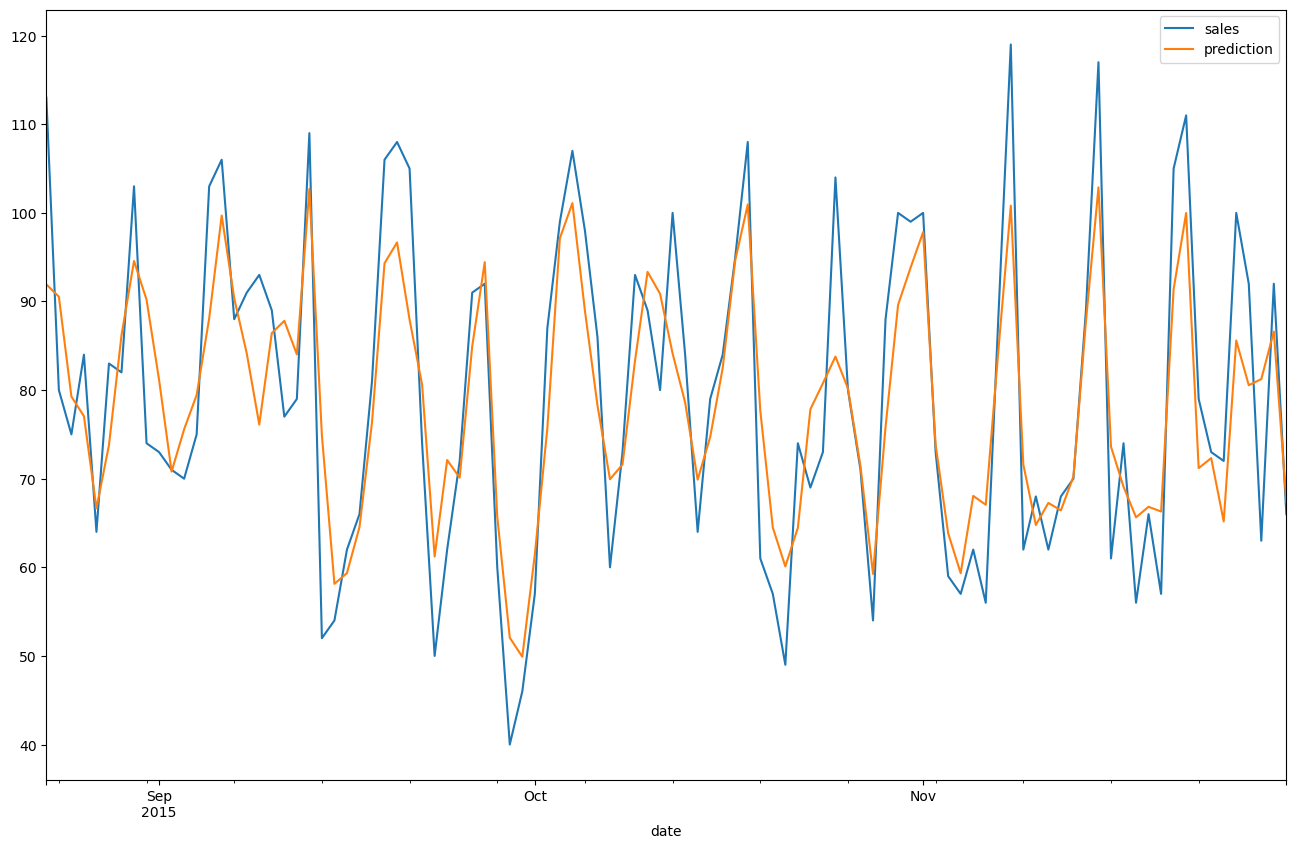

In [14]:
temp.tail(100).plot(figsize = (16,10));

In [15]:
# if this would be very different, 
# probably there would be a problem in the process


## Scale to all the products

In [16]:
# We already have this working to model a product
# now we need to scale up to all the combinations of shops and products

In [17]:

x = pd.read_pickle('../../02_Data/03_Work/x_preselected.pickle')
y = pd.read_pickle('../../02_Data/03_Work/y_preselected.pickle')


In [18]:
# combine shop and product as a new variable
# drop the originals
x.insert(loc=0,column='product',value=x.store_id + '_'+ x.item_id)
x = x.drop(columns = ['store_id','item_id'])

In [19]:
products = list(x.groupby('product')) 
# this is a list of the different dataframes for each product

In [52]:
# Encapsulating


#get x and y for each product

def model_each(x_product, y):
          
    # exclude product as model variable
    var_to_model = x_product.columns.to_list()[2:]
    
    #Define cross validation
    time_cv = TimeSeriesSplit(3, test_size = 8)
    
    # define algorythm pipe
    pipe = Pipeline([('algorythm', HistGradientBoostingRegressor())])
    
    grid = [ 
         {'algorythm': [HistGradientBoostingRegressor()]#, # after some tries, default works the best
#         'algorythm__learning_rate': [0.01,0.025,0.05,0.1],
#         'algorythm__max_iter': [50,100,200],
#         'algorythm__max_depth': [None, 5,10,20],
#         'algorythm__min_samples_leaf': [20, 500],
#         'algorythm__l2_regularization': [0,0.25,0.5,0.75,1]
        }
                       
    ]
           
    #create the models
    random_search = RandomizedSearchCV(estimator = pipe,
                                       param_distributions = grid, 
                                       n_iter = 1, #30, 
                                       cv = time_cv, 
                                       scoring = 'neg_mean_absolute_error', 
                                       verbose = 0,
                                       n_jobs = -1)

    
    model = random_search.fit(x_product[var_to_model],y)
    
    final_model = model.best_estimator_.fit(x_product[var_to_model],y)
    
    return(final_model)


    

    

In [53]:
# list for the trained models for each product

models_list = []

In [54]:
for each in products:

    product = each[0]
    data = each[1]

    y_each = y[y.index.isin(data.index)]

    model = model_each(data,y_each)
    models_list.append((product,model))
    

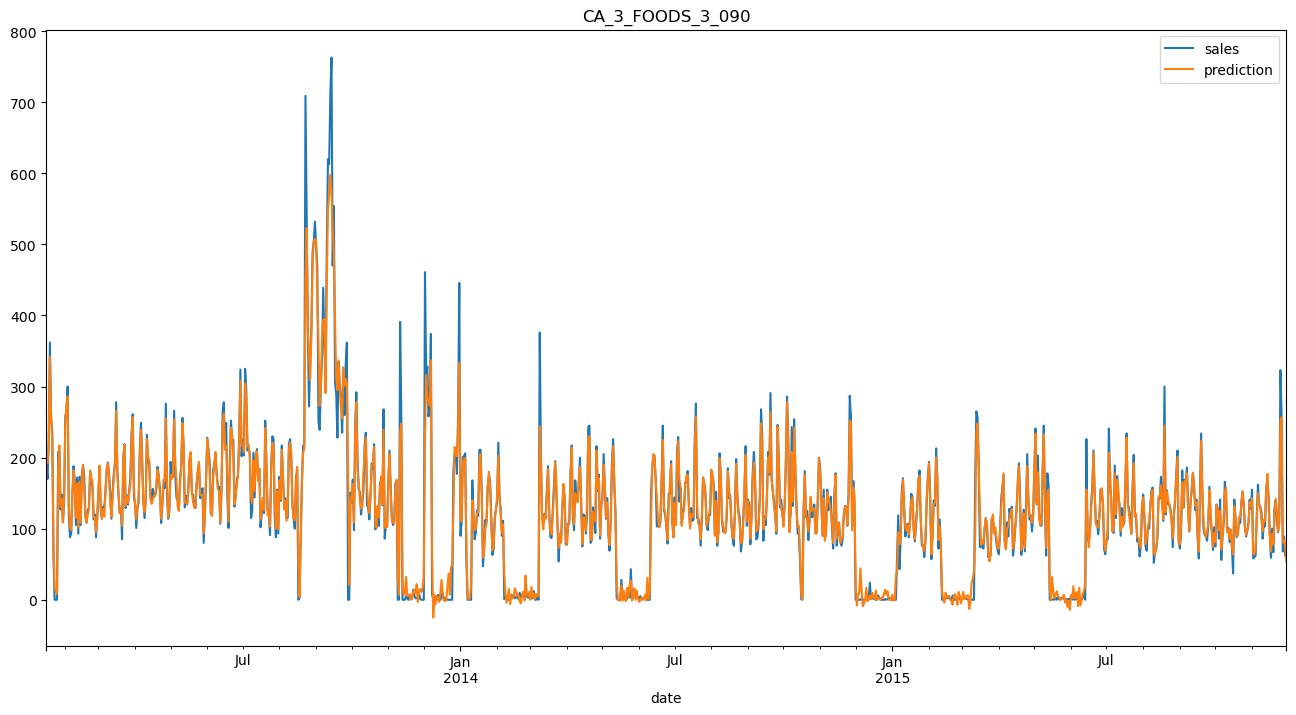

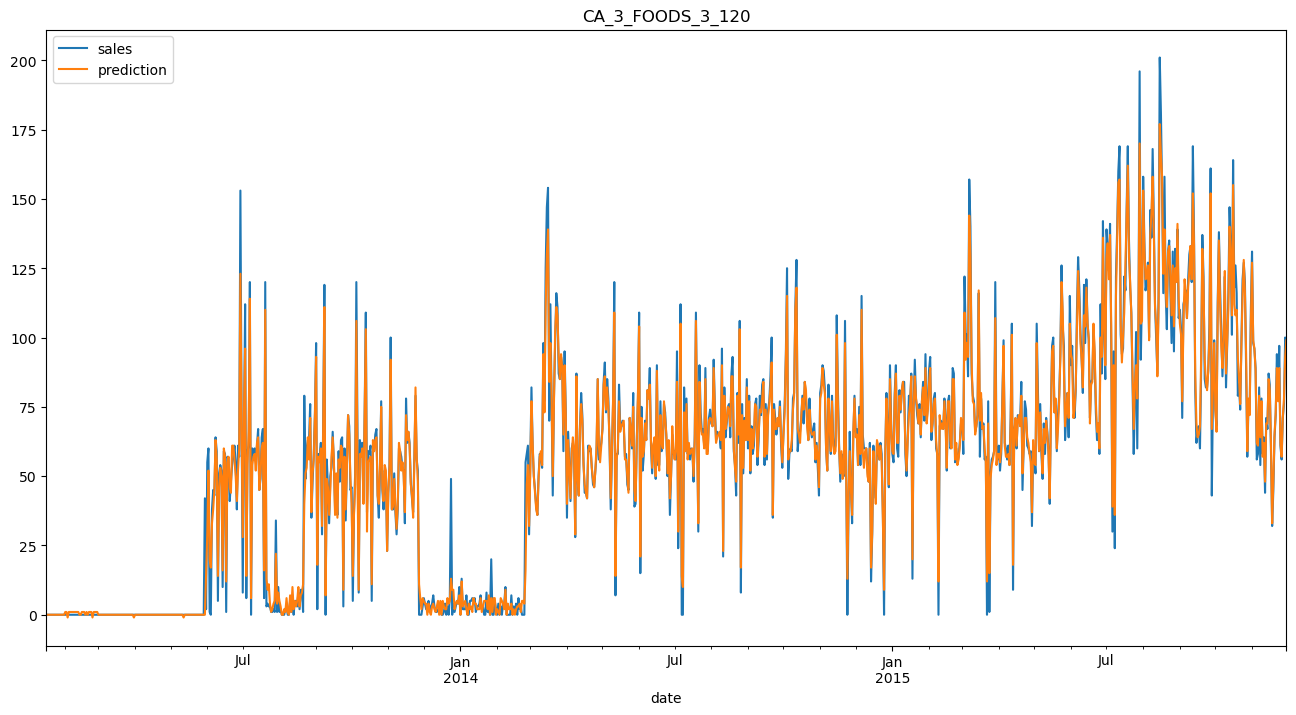

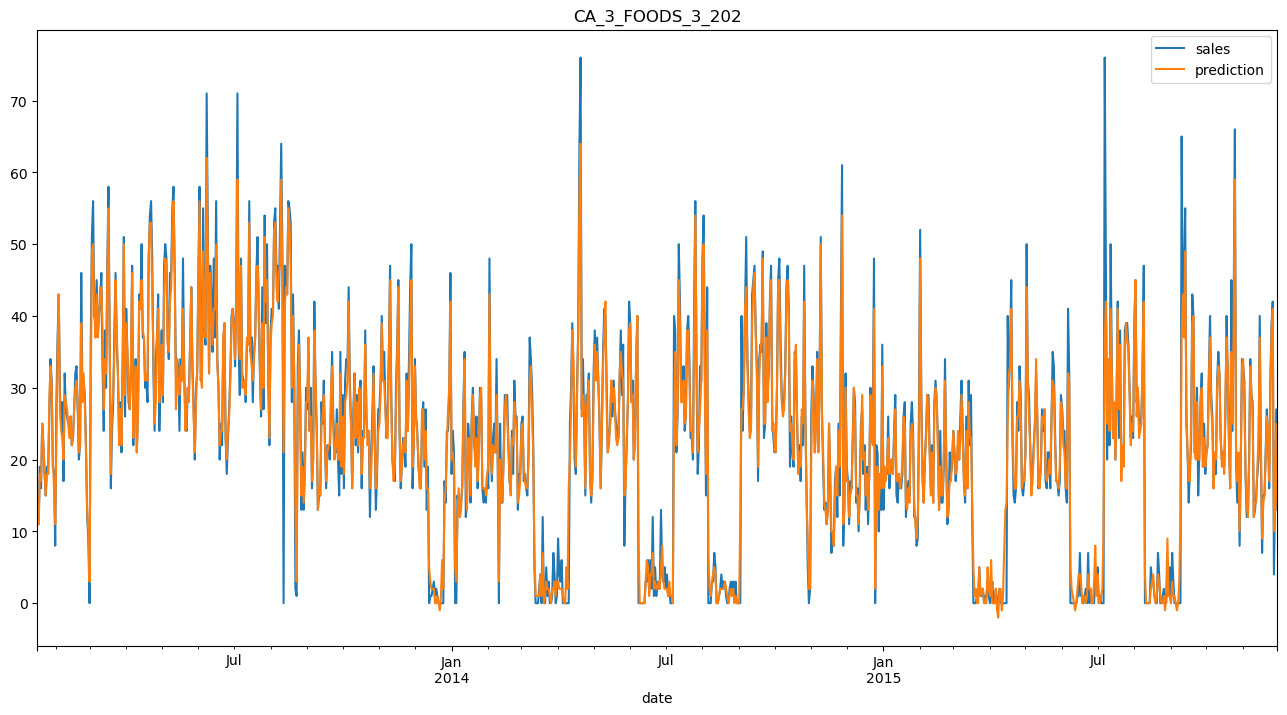

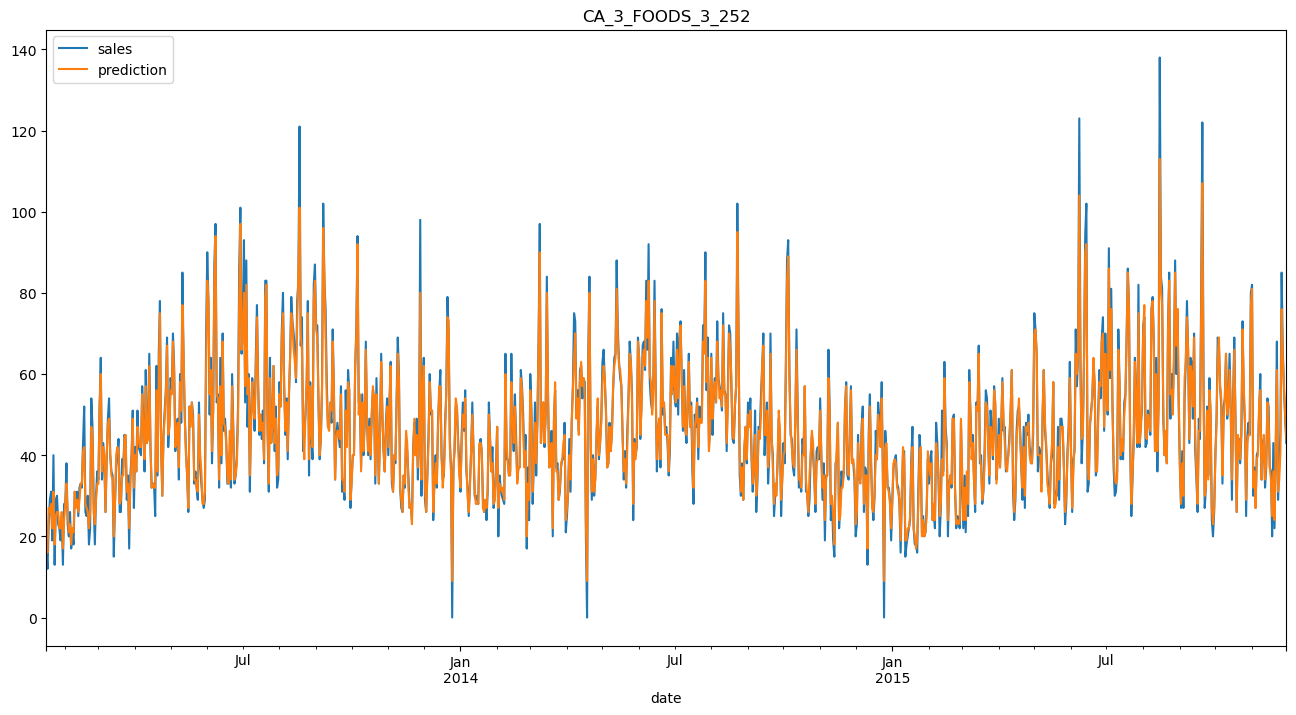

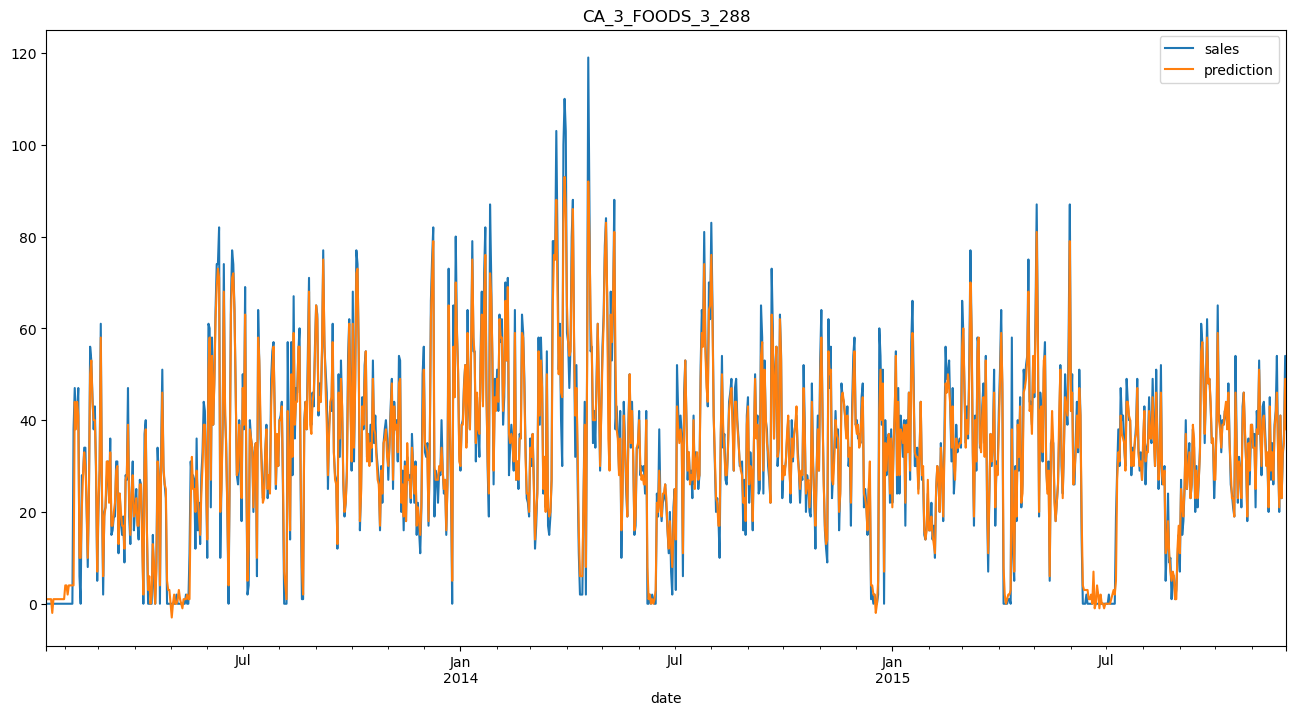

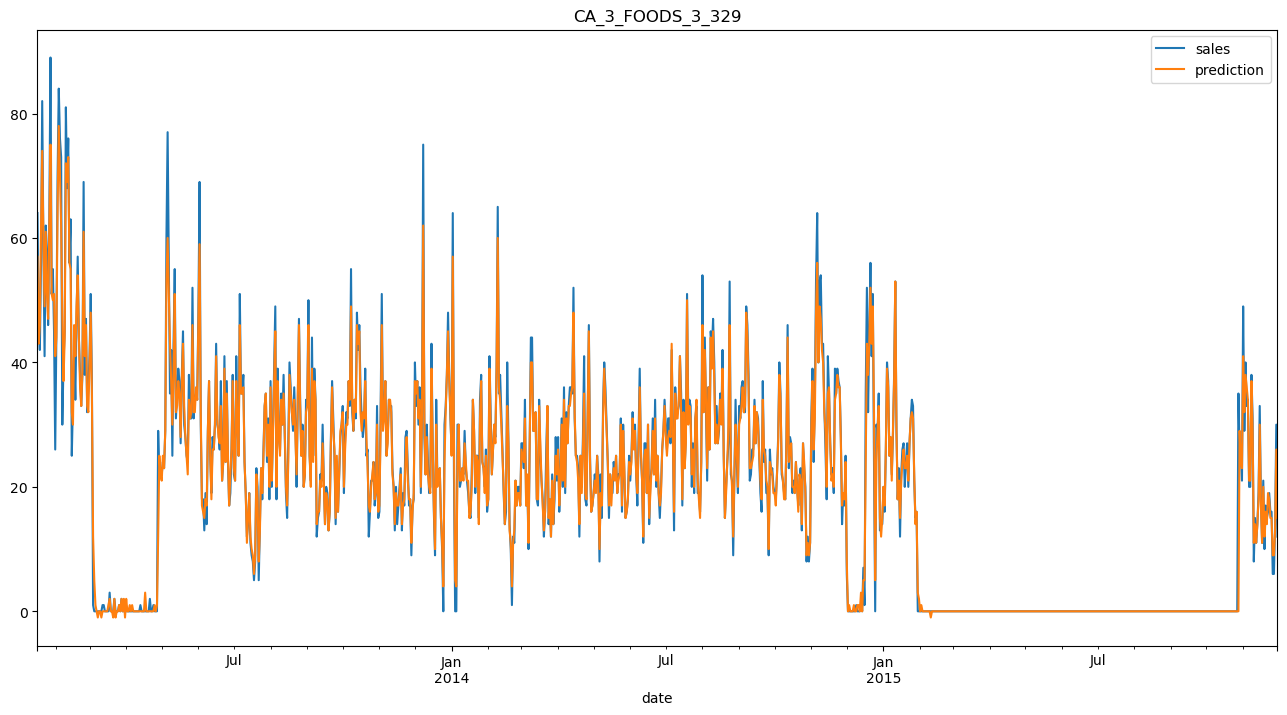

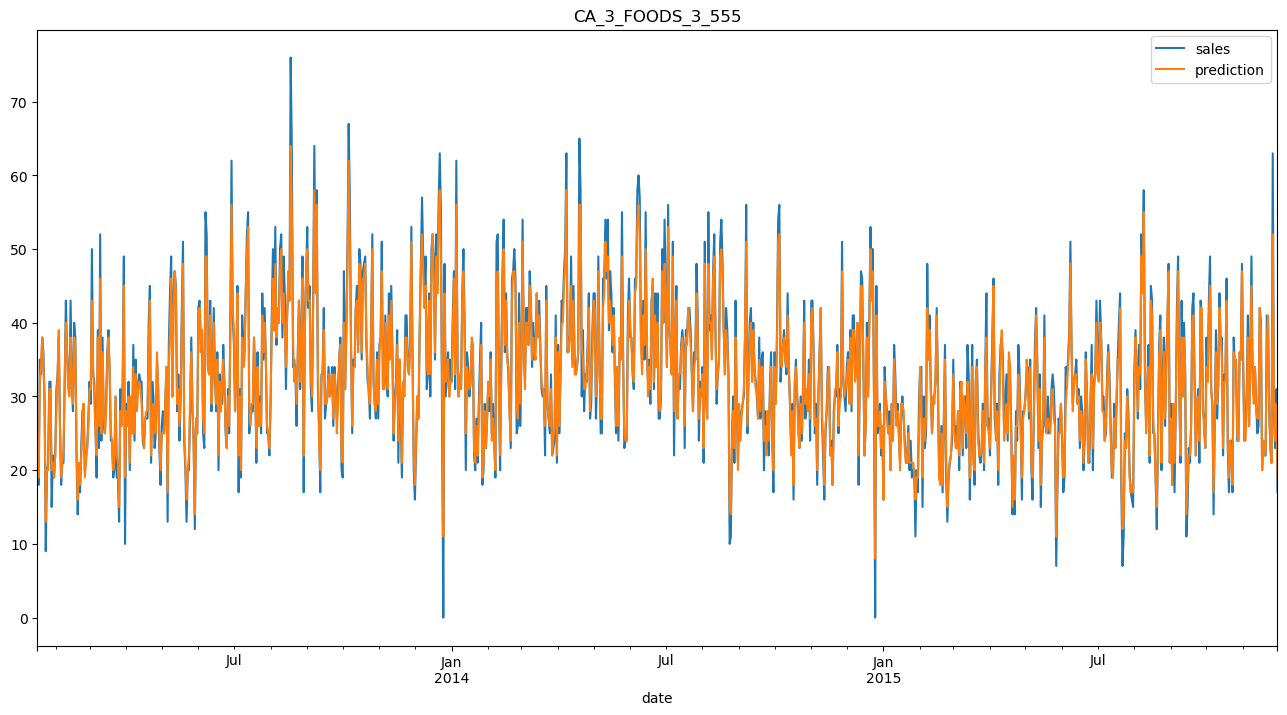

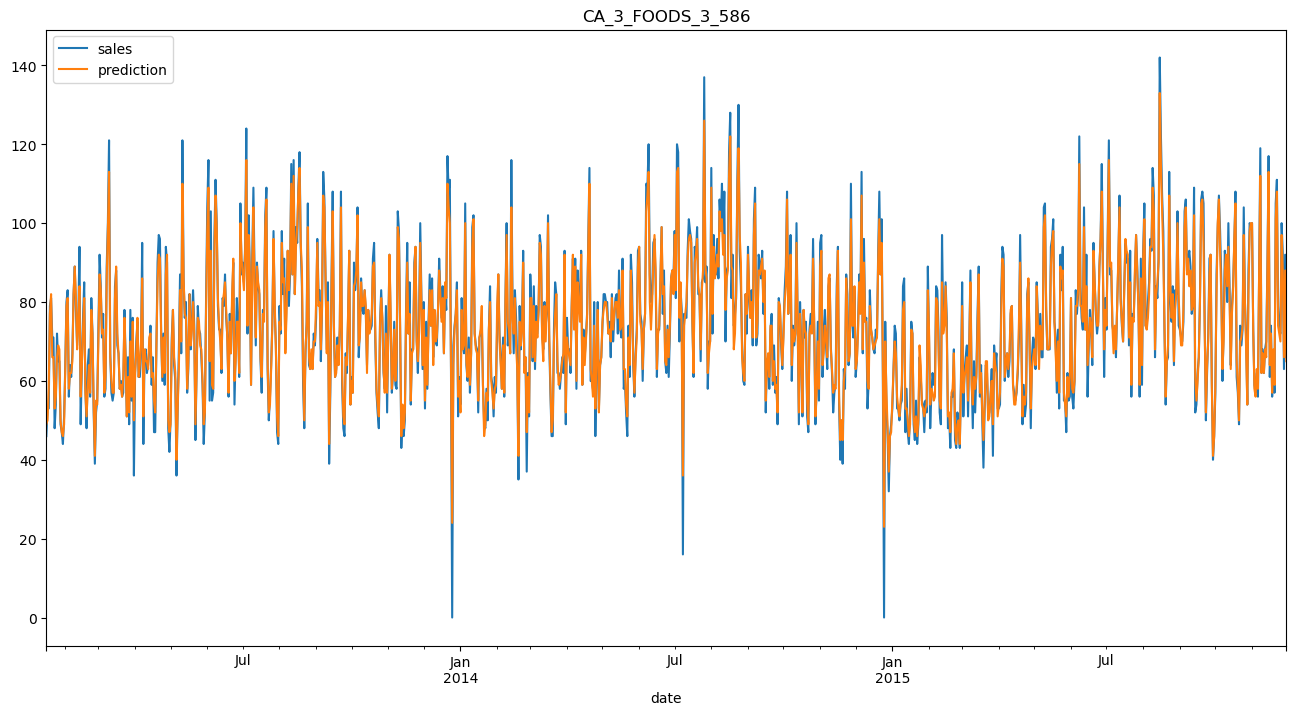

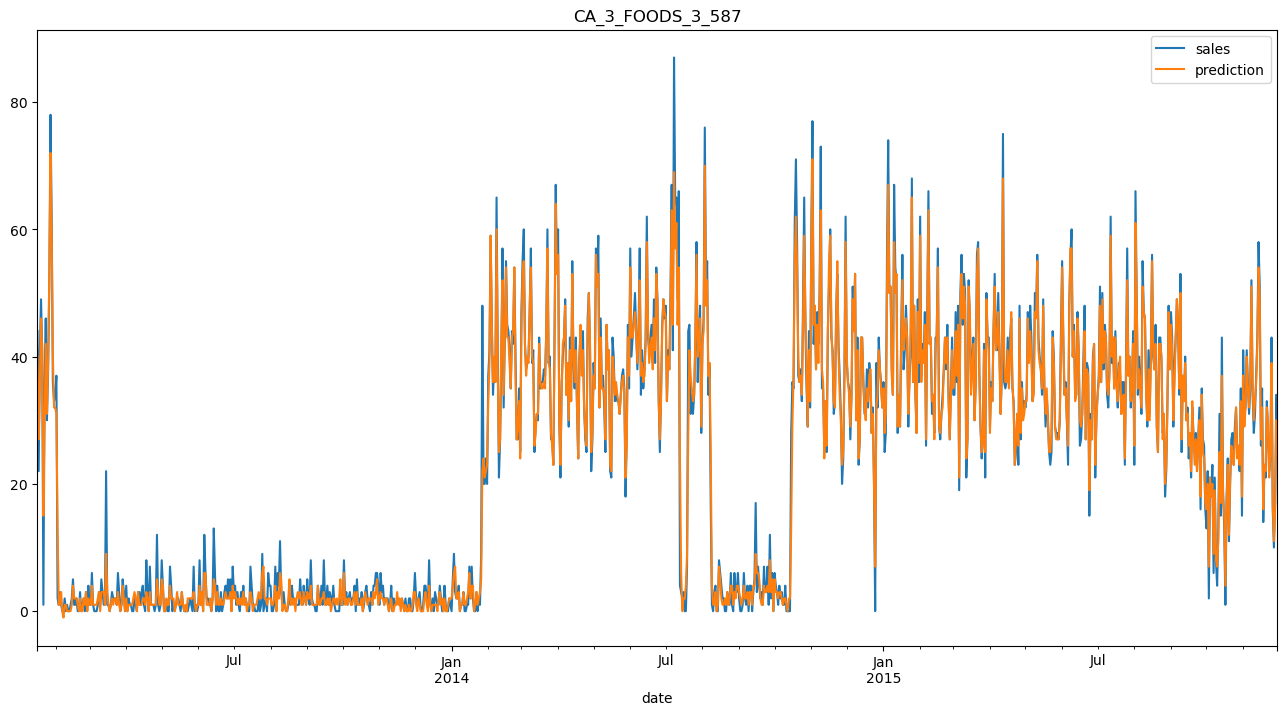

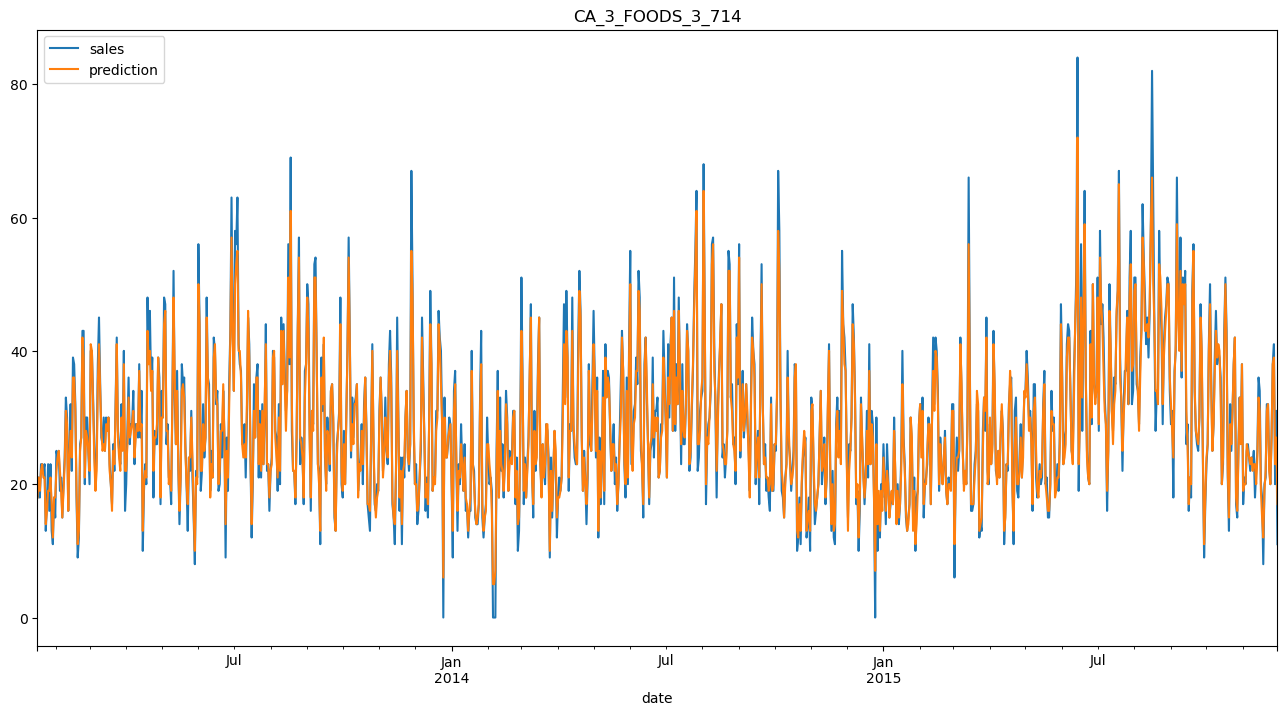

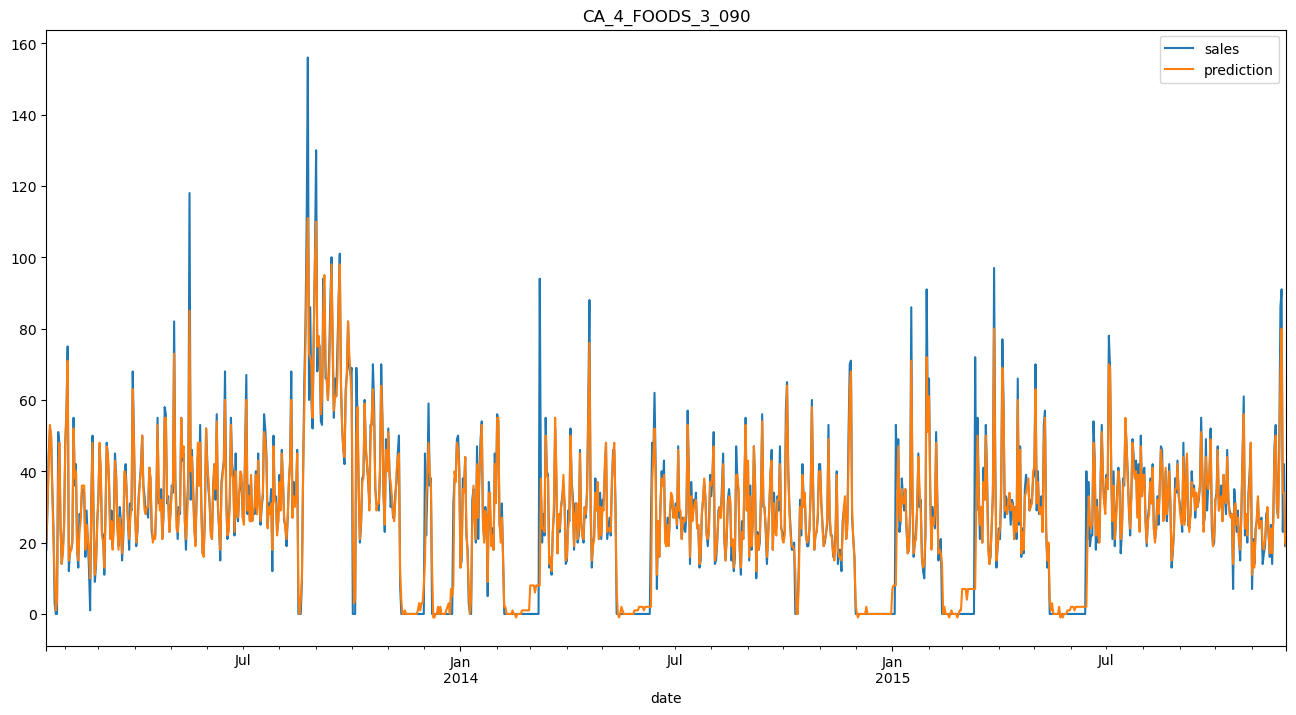

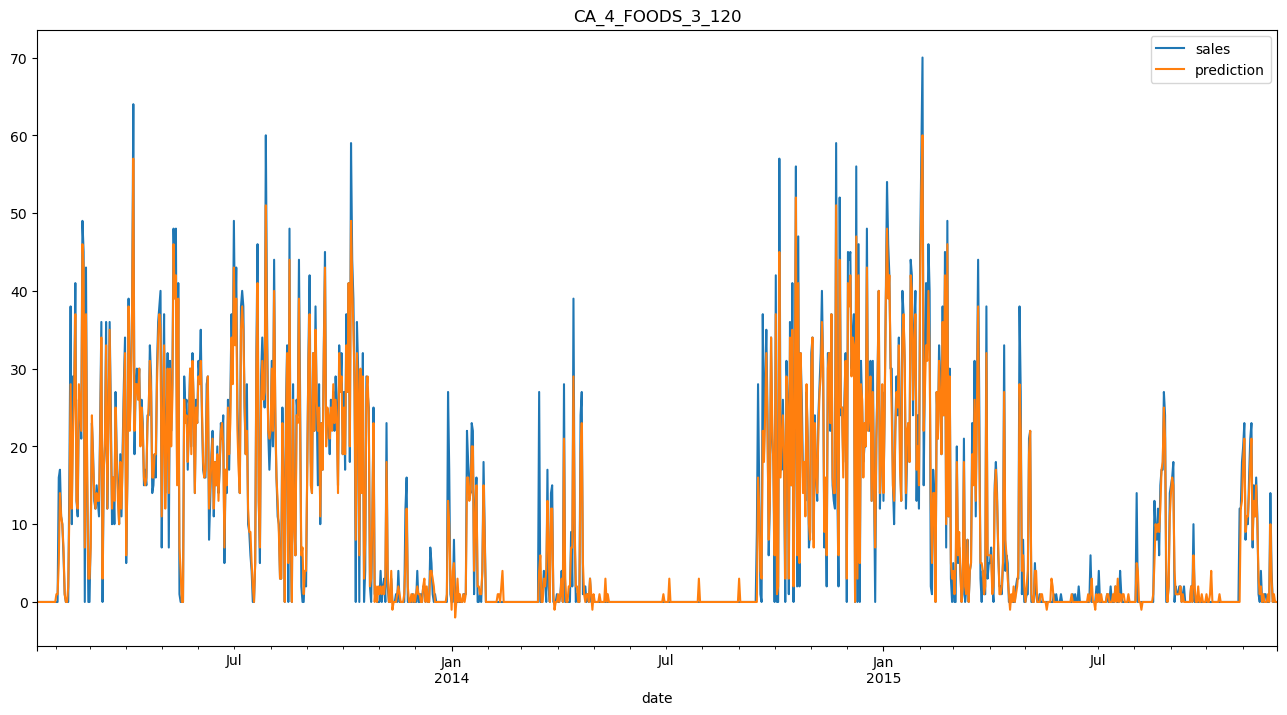

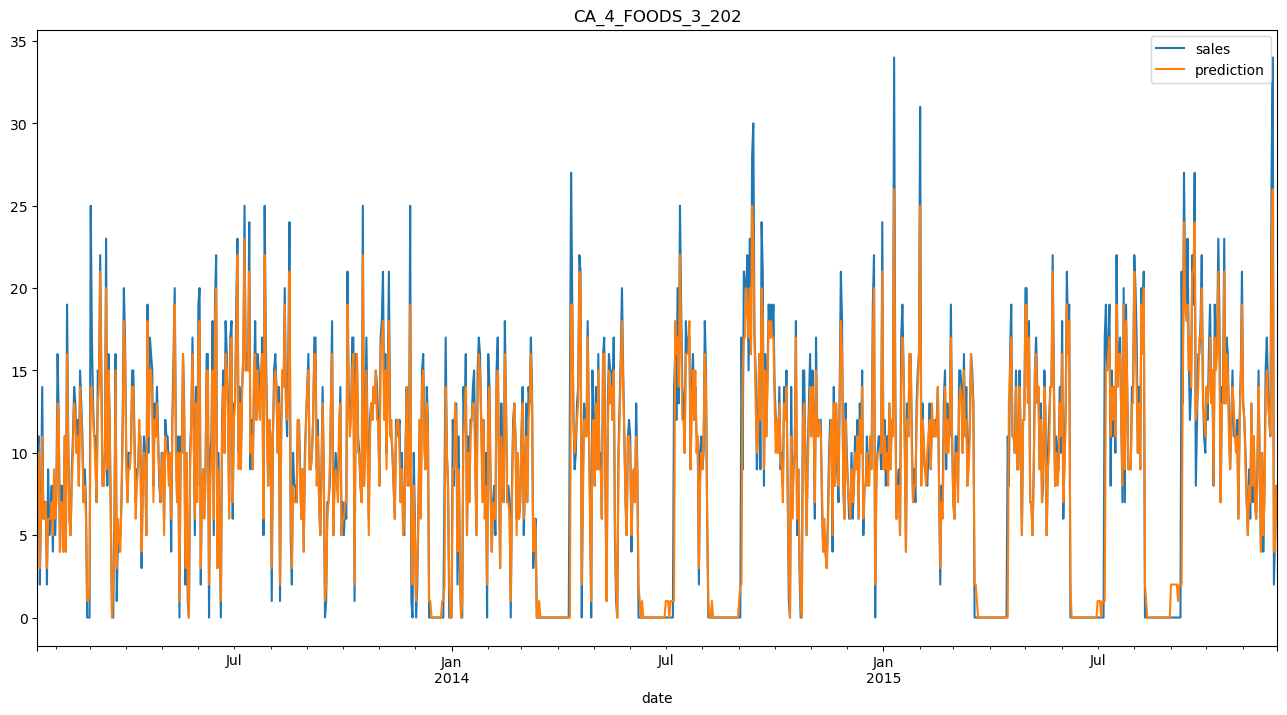

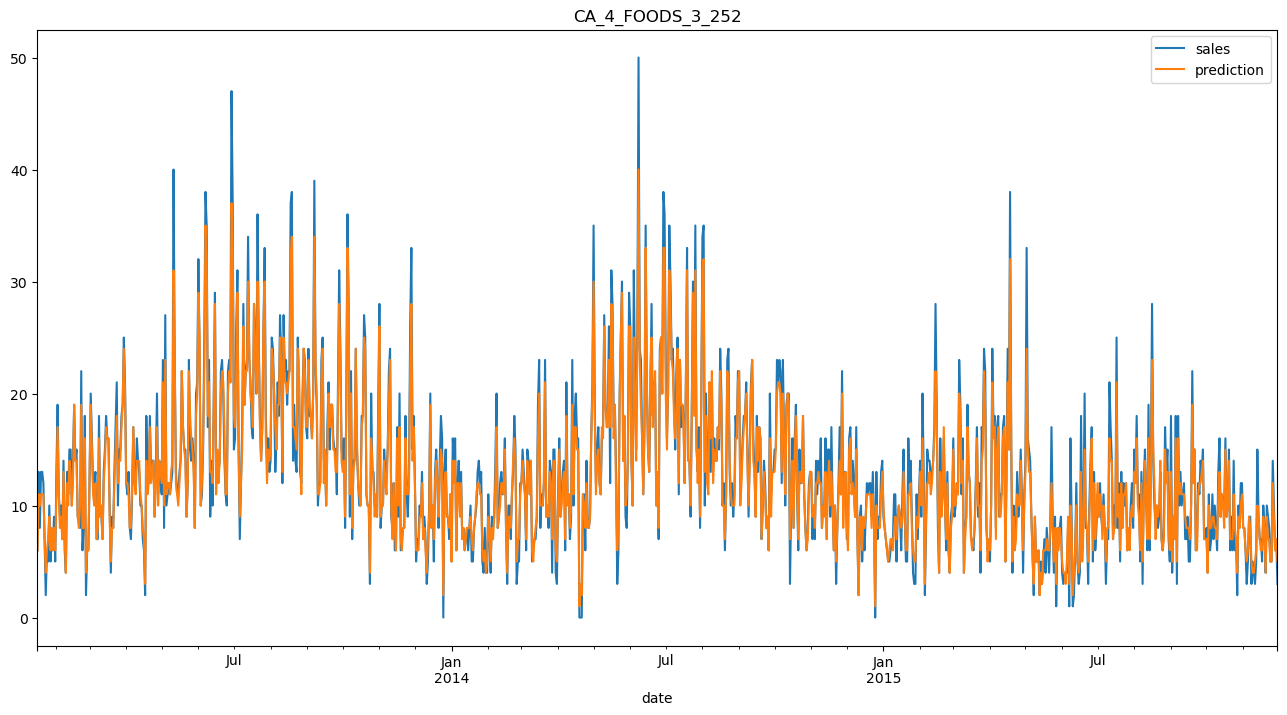

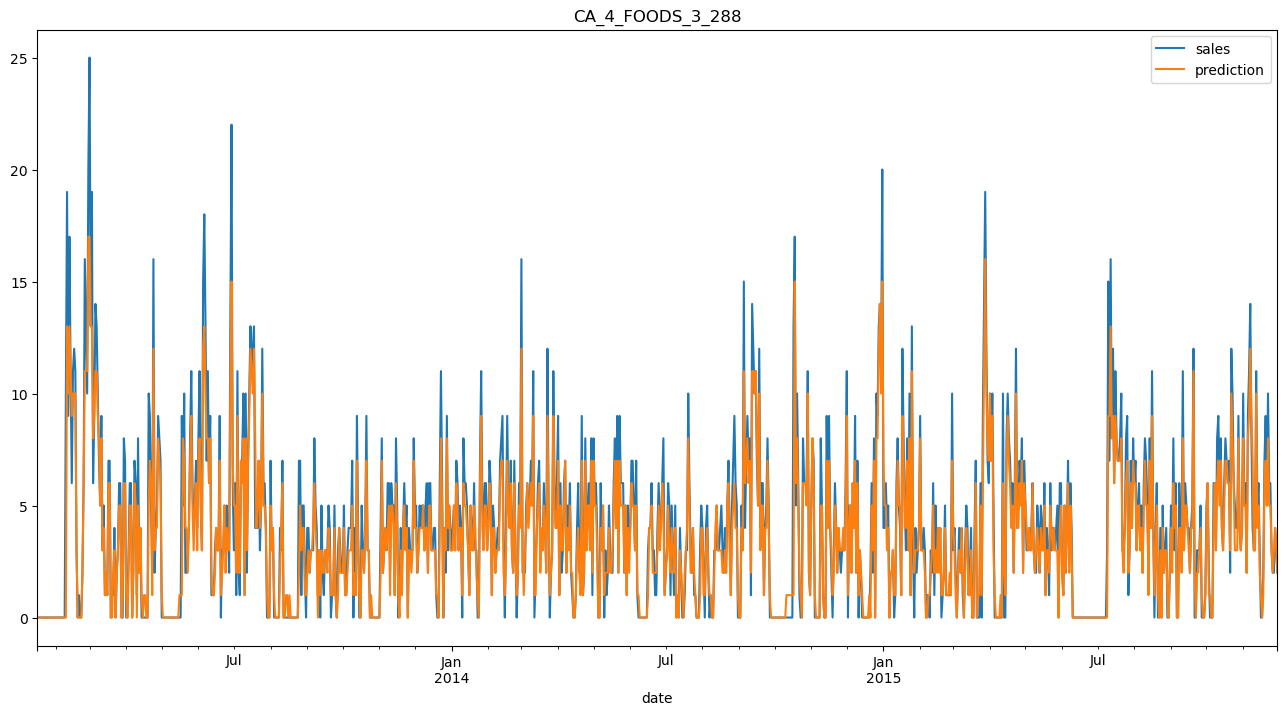

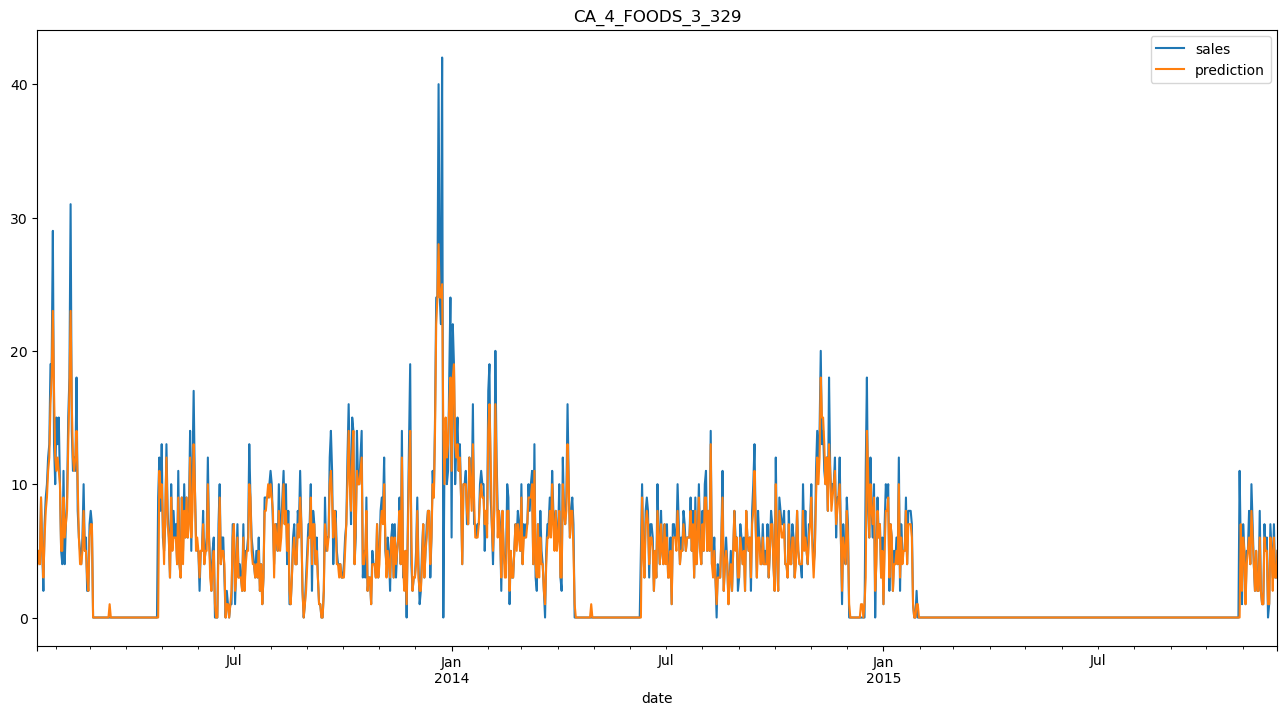

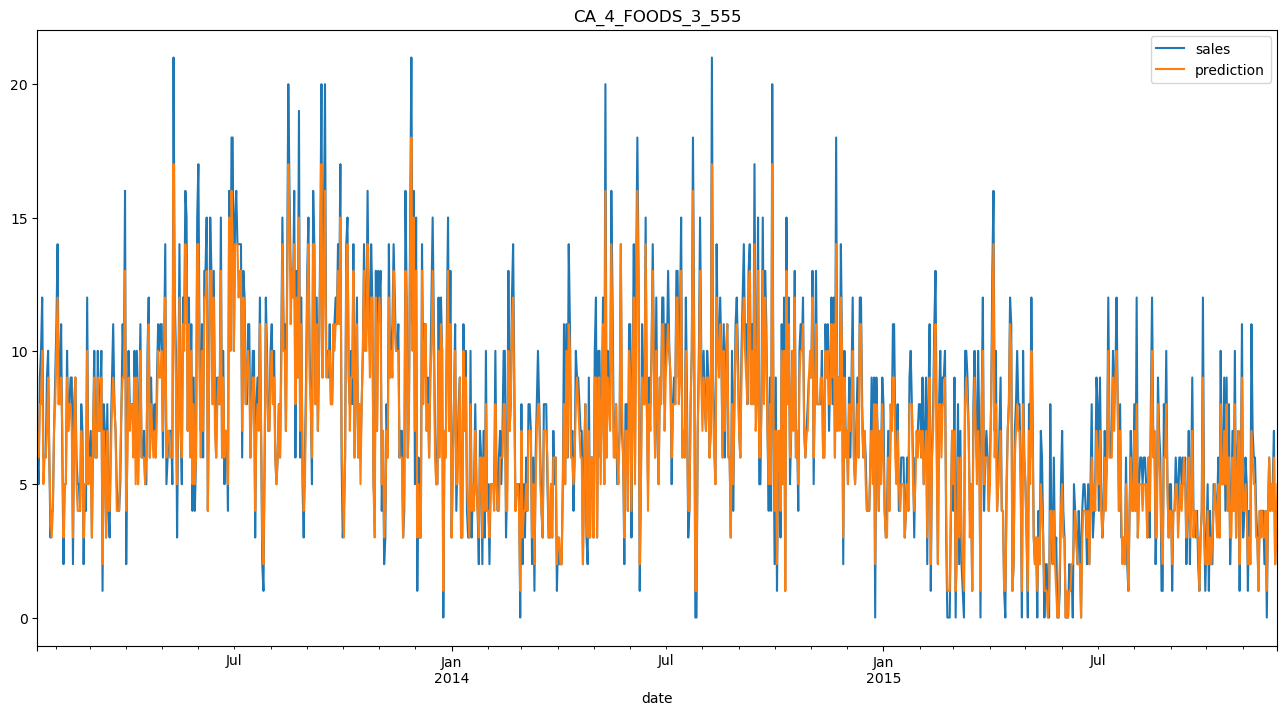

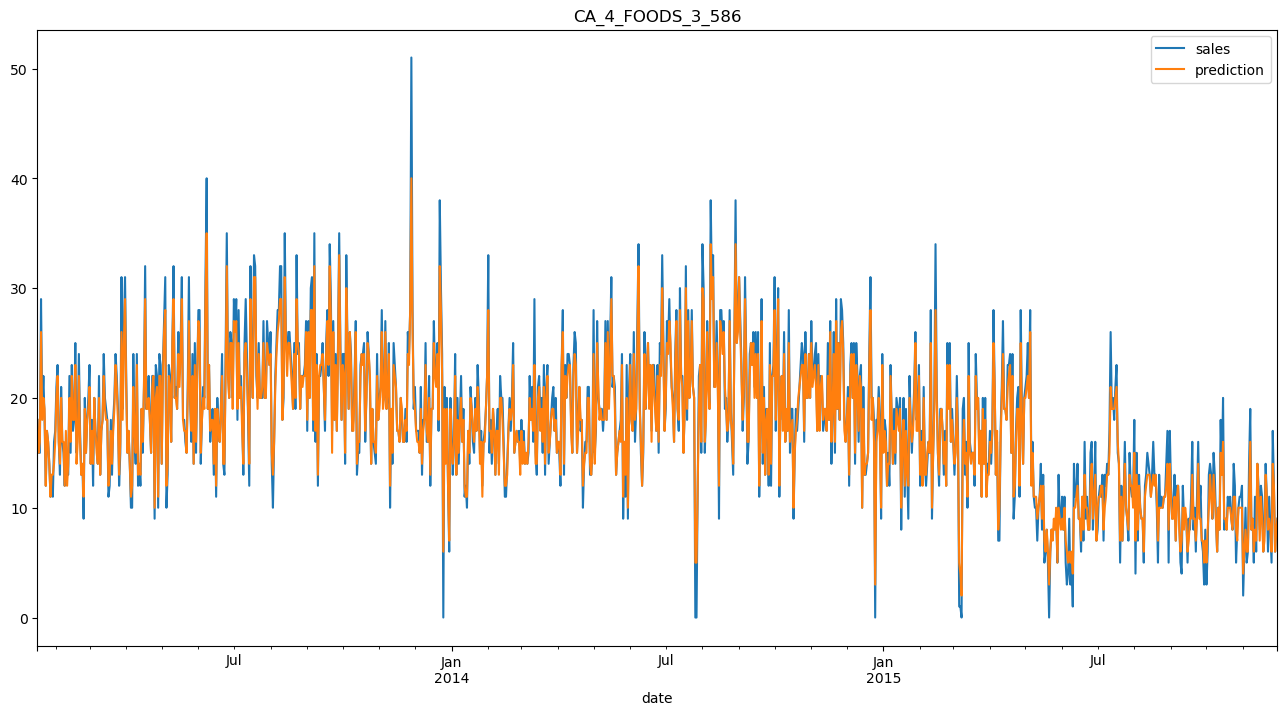

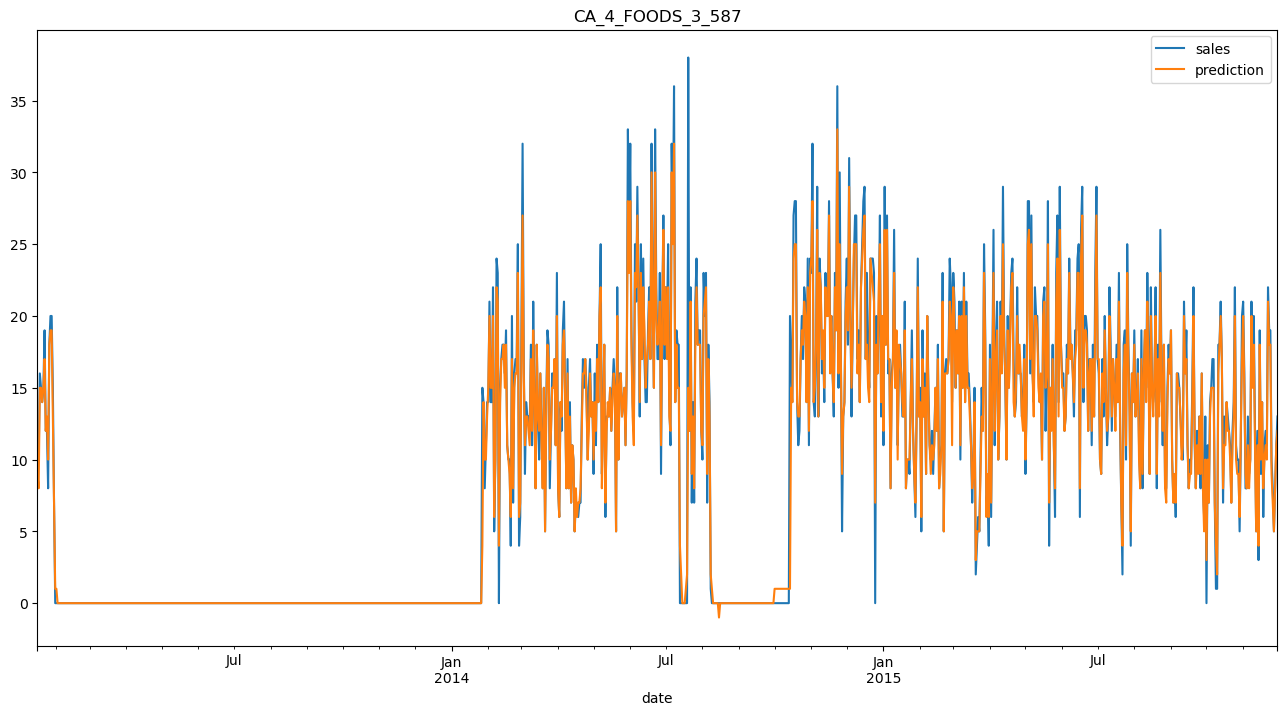

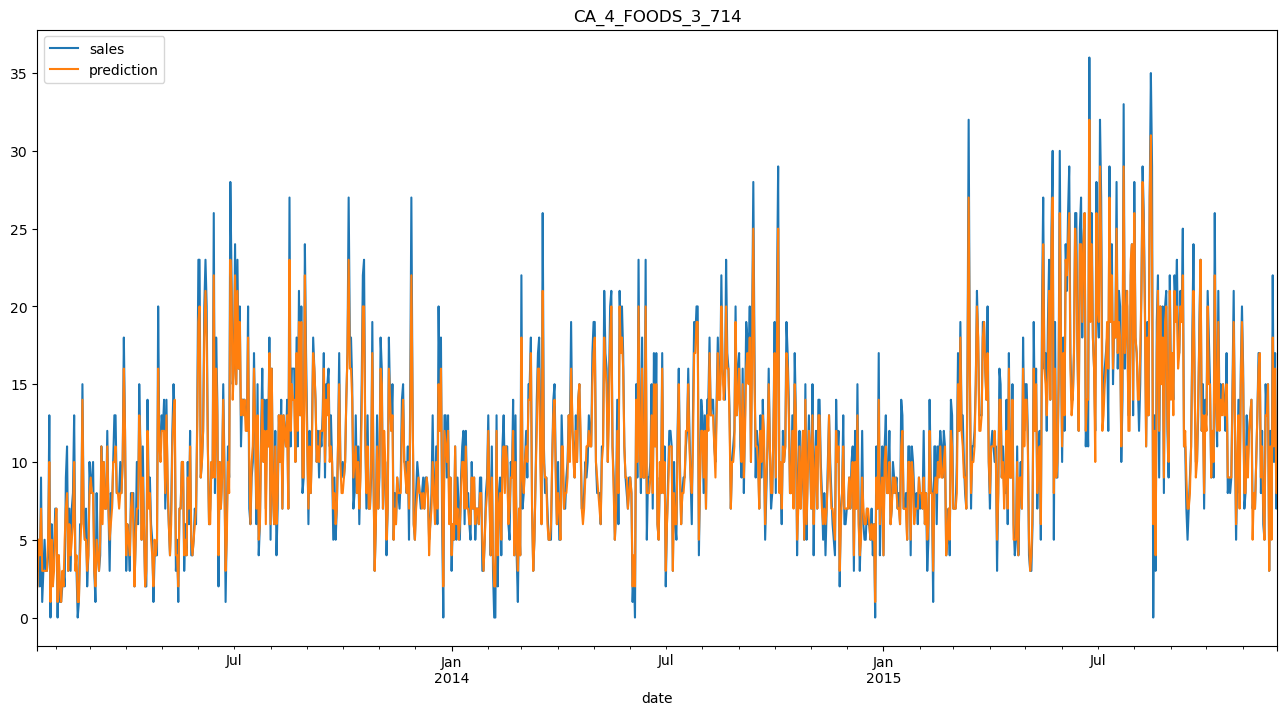

In [57]:
df =  pd.concat([x,y],axis=1)

for each in range(0,len(models_list)):
    
    #prepare the data
    product = models_list[each][0]
    model = models_list[each][1]
    variables = model[0].feature_names_in_ #variables may change in different each
    target = 'sales'

    x_prod = df.loc[df['product'] == product].drop(columns=target).copy()
    y_prod = df.loc[df['product'] == product,'sales'].copy()

    date = x_prod.date.values
    
    #Generate plots of predicted vs real
    predictions = pd.DataFrame(data={'date': date,
                                      'product': product,
                                      'sales': y_prod,
                                      'prediction': model.predict(x_prod[variables])})

    predictions['prediction'] = predictions.prediction.astype('int')
    predictions.set_index('date',inplace=True)

    predictions.plot(figsize = (16,8),title = product);
    #predictions.tail(100).plot(figsize = (16,8),title = product); # zoom last 100